# Different regression problem formulations

In [1]:
import pandas
import glob
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
%matplotlib inline

# Sequences with very few plasmids give unreliable outputs.
# A cutoff of 20 DNA counts is recommended by Ernst et. al.
DNA_COUNT_THRESH = 20

cells = ["HepG2", "K562"]
designs = ["ScaleUpDesign1", "ScaleUpDesign2"]
promoters = ["minP", "SV40P"]

In [2]:
def quantile_plot(x, y, quantiles = 5000, ax = None, s = 5):
    assert x.shape == y.shape
    data_pairs = [(X, Y) for X, Y in zip(x, y)]
    data_pairs = sorted(data_pairs, key = lambda x: x[0])
    avg_activity, avg_score = [], []
    for i in range(0, len(data_pairs), len(data_pairs) / quantiles):
        index = range(i, min(i + (len(data_pairs) / quantiles), len(data_pairs)))
        activities = [data_pairs[j][0] for j in index]
        scores  = [data_pairs[j][1] for j in index]
        avg_activity.append(sum(activities) / float(len(activities)))
        avg_score.append(sum(scores) / float(len(scores)))
    if ax:
        ax.scatter(avg_activity, avg_score, c = 'r', s=s)
    else:
        plt.scatter(avg_activity, avg_score, c = 'r', s=s)
        plt.show()

In [3]:
def read_counts(fn):
    data = pandas.read_csv(fn, sep= '\t', header = 0)
    names  = data[["ID"]].as_matrix().reshape(-1)
    seq    = data[["Sequence"]].as_matrix().reshape(-1)
    counts = data[["Counts"]].as_matrix().reshape(-1).astype('int')
    return names, seq, counts

In [4]:
def normalize(rna, dna):
    activities = np.zeros(rna.shape)
    activities.fill(float('inf'))
    valid = dna > DNA_COUNT_THRESH
    activities[valid] = scale(np.log2(rna[valid] + 1) - np.log2(dna[valid] + 1)
                              - np.log2(sum(rna[valid] + 1)) + np.log2(sum(dna[valid] + 1)))
    return activities

In [5]:
def get_counts(cell, promoters, design, names=None, seqs=None):
    # Find relevant files.
    # Note that there is one plasmid library used for each promoter.
    rna1 = glob.glob("raw/*{}_{}_{}_mRNA_Rep1*".format(cell, design, promoter))
    rna2 = glob.glob("raw/*{}_{}_{}_mRNA_Rep2*".format(cell, design, promoter))
    dna  = glob.glob("raw/*{}_{}_Plasmid*".format(design, promoter))
    assert len(rna1) == len(rna2) == len(dna) == 1

    # Read in names, sequences, and counts.
    rna1_names, rna1_seqs, rna1_counts = read_counts(rna1[0])
    rna2_names, rna2_seqs, rna2_counts = read_counts(rna2[0])
    dna_names,  dna_seqs,  dna_counts  = read_counts(dna[0])

    # ... and assure that they are concordant.
    assert np.all(rna1_seqs == rna2_seqs) and np.all(rna2_seqs == dna_seqs)
    assert np.all(rna1_names == rna2_names) and np.all(rna2_names == dna_names)
    assert rna1_counts.shape == rna2_counts.shape == dna_counts.shape

    # ... and they match the previously read names and sequences.
    if names is not None:
        assert np.all(names == dna_names)
        assert np.all(seqs  == dna_seqs)
    seqs, names = dna_seqs, dna_names
    return names, seqs, rna1_counts, rna2_counts, dna_counts

# Read in Data

In [6]:
names = {}
seqs = {}
rna1 = {}
rna2 = {}
dna  = {}
for design in designs:
    names[design] = None
    seqs[design]  = None
    rna1[design] = []
    rna2[design] = []
    dna[design] = []
    header = ['Name']
    for cell in cells:
        for promoter in promoters:
            header += ["{}-{}".format(cell, promoter)]
            (names[design], seqs[design],
             r1, r2, d) = get_counts(cell, promoters, design,
                                     names[design], seqs[design])
            rna1[design] += [r1]
            rna2[design] += [r2]
            dna[design] += [d]
    rna1[design] = np.vstack(rna1[design]).T
    rna2[design] = np.vstack(rna2[design]).T
    dna[design] = np.vstack(dna[design]).T
    assert rna1[design].shape == rna2[design].shape == dna[design].shape

In [7]:
def act(rna, dna, thresh = 20):
    rna, dna = rna[dna > thresh], dna[dna > thresh]
    return (np.log(rna + 1) - np.log(dna + 1)
            - np.log(sum(rna + 1)) + np.log(sum(dna + 1)))

In [9]:
disps = []
with open('disp.txt') as fp:
    fp.readline()
    for line in fp:
        disp = line.strip().split()[1]
        disps += [float(20 if disp == 'NA' else disp)]
disps = np.array(disps)
print disps.shape
print disps[0]

(243573,)
0.658305630104


In [10]:
lfc = []
lfc_se = []
pvals = []
with open('deseq.txt') as fp:
    print fp.readline()
    for line in fp:
        name, mean, lf2c, lf2c_se, stat, pval, padj = line.strip().split('\t')
        lfc    += [float(0 if lf2c == 'NA' else lf2c)]
        lfc_se += [float(0 if lf2c_se == 'NA' else lf2c_se)]
        pvals  += [float(1 if pval == 'NA' else pval)]
lfc = np.array(lfc)
lfc_se = np.array(lfc_se)
pvals = np.array(pvals)

"baseMean"	"log2FoldChange"	"lfcSE"	"stat"	"pvalue"	"padj"



# Shared Functions and Data

In [26]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
design = 'ScaleUpDesign1'
BASES = ['A', 'C', 'G', 'T']
r1, r2 = rna1[design][:, 0], rna2[design][:, 0]
d = dna[design][:, 0]
def kmerize(X, k):
    bases = ['00', '01', '10', '11']
    counts = []
    for seq in X:
        binary_seq = ''.join(map(lambda x: bases[x], seq))
        count = np.zeros((4**k,), dtype = int)
        for i in range(0, len(seq) - k + 1):
            count[int(binary_seq[i*2:(i+k)*2], 2)] += 1
        counts += [count]
    return np.vstack(counts)

def seqs_to_matrix(seqs):
    return np.vstack([map(lambda x: BASES.index(x), seq)
                     for seq in seqs])

def get_X(idx, k):
    return kmerize(seqs_to_matrix(seqs[design][idx]), k)

def get_y(idx):
    a1, a2 = act(r1, d, -1), act(r2, d, -1)
    return scale((a1+a2)[idx]/2.0)

def evaluate(true, pred):
    print stats.spearmanr(true, pred)
    print stats.pearsonr(true, pred)
    plt.scatter(true, pred, s= 1, lw = 0)
    plt.show()

# Compare Different models trained with all data

In [25]:
X = get_X(d > 20, 6)
y = get_y(d > 20)
y_lfc = lfc[d > 20]
w = (1-pvals)[d > 20]

(X_train, X_test,
 y_train, y_test,
 y_shrunk_train, y_shrunk_test,
 w_train, w_test) = train_test_split(X, y, y_lfc, w,
                                     test_size = 0.2,
                                     random_state = 42)

normal_model   = SGDRegressor(penalty = 'l1').fit(X_train, y_train)
shrunken_model = SGDRegressor(penalty = 'l1').fit(X_train,
                                                  y_shrunk_train)
weighted_model = SGDRegressor(penalty = 'l1').fit(X_train, y_train,
                                                 sample_weight = w_train)

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


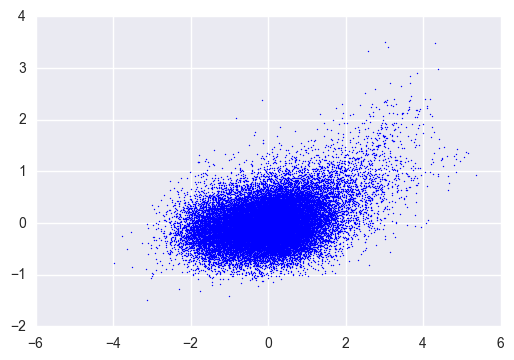

SpearmanrResult(correlation=0.25155767278852531, pvalue=0.0)
(0.37037183744031821, 0.0)


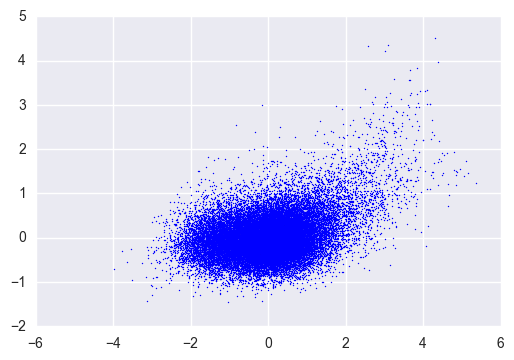

SpearmanrResult(correlation=0.27821431606799119, pvalue=0.0)
(0.37729222384897754, 0.0)


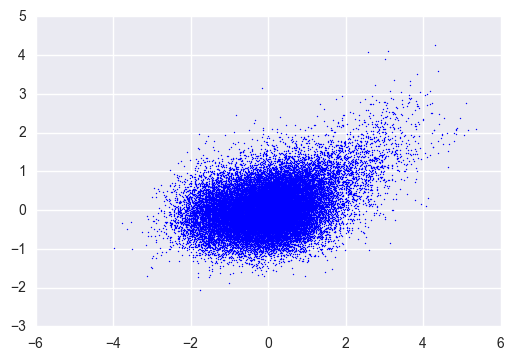

In [27]:
evaluate(y_test, normal_model.predict(X_test))
evaluate(y_test, shrunken_model.predict(X_test))
evaluate(y_test, weighted_model.predict(X_test))

SpearmanrResult(correlation=0.2527775367718188, pvalue=0.0)
(0.39133486210193602, 0.0)


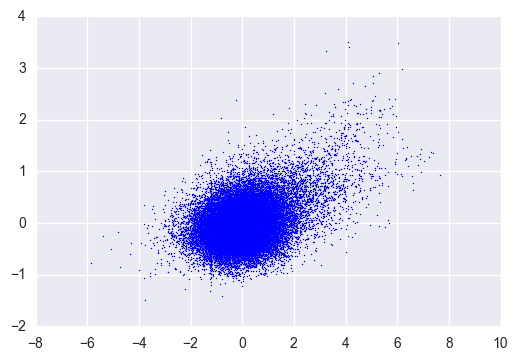

SpearmanrResult(correlation=0.24624168029218063, pvalue=0.0)
(0.4044789325716901, 0.0)


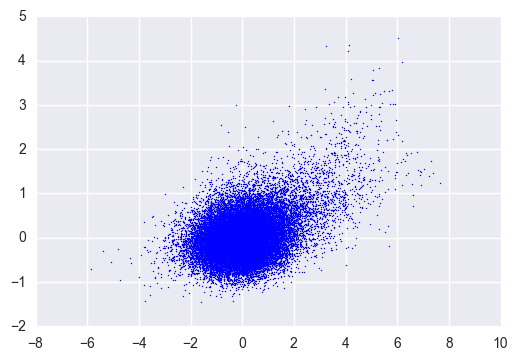

SpearmanrResult(correlation=0.26064943520098721, pvalue=0.0)
(0.3953108685194367, 0.0)


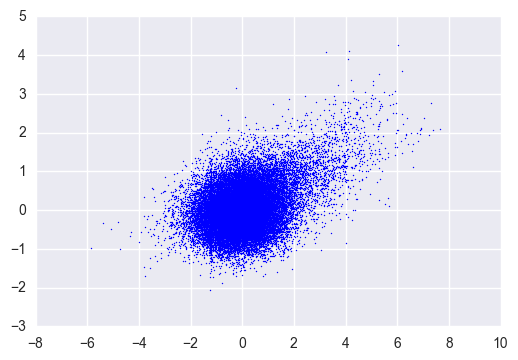

In [28]:
evaluate(y_shrunk_test, normal_model.predict(X_test))
evaluate(y_shrunk_test, shrunken_model.predict(X_test))
evaluate(y_shrunk_test, weighted_model.predict(X_test))

# Model Trained on only High DNA counts

In [29]:
s_X = get_X(d > 200, 6)
s_y = get_y(d > 200)

(s_X_train, s_X_test,
 s_y_train, s_y_test) = train_test_split(s_X, s_y,
                                     test_size = 0.2,
                                     random_state = 42)

selective_model = SGDRegressor(penalty = 'l1').fit(s_X_train, s_y_train)

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


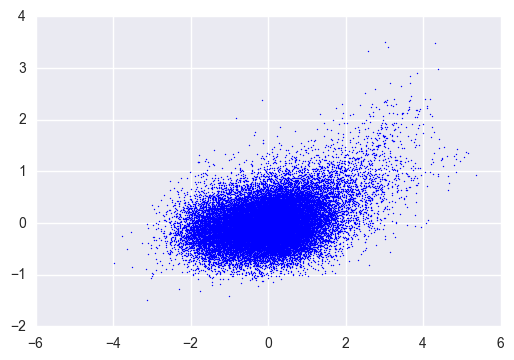

SpearmanrResult(correlation=0.25291142409335221, pvalue=0.0)
(0.35900474926506259, 0.0)


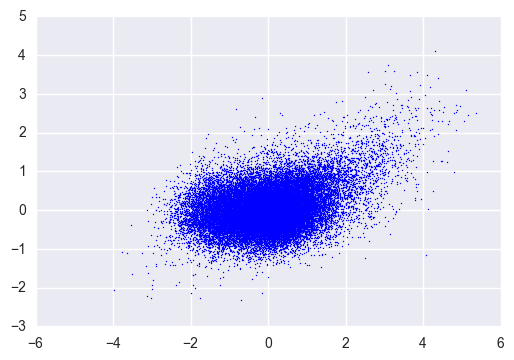

In [30]:
evaluate(y_test, normal_model.predict(X_test))
evaluate(y_test, selective_model.predict(X_test))

SpearmanrResult(correlation=0.31999315812904905, pvalue=2.0007213351208669e-257)
(0.46623185872680228, 0.0)


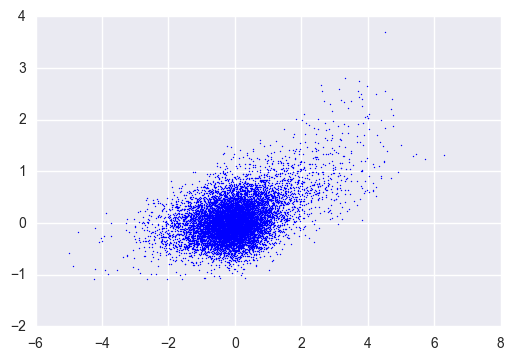

SpearmanrResult(correlation=0.31154838659481998, pvalue=1.9997206427733358e-243)
(0.4673487365810659, 0.0)


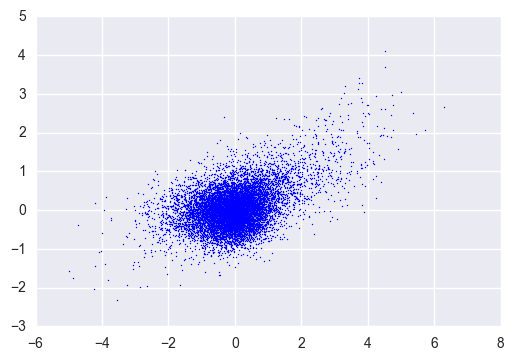

SpearmanrResult(correlation=0.32548796488027337, pvalue=8.811369024513902e-267)
(0.46788586450595271, 0.0)


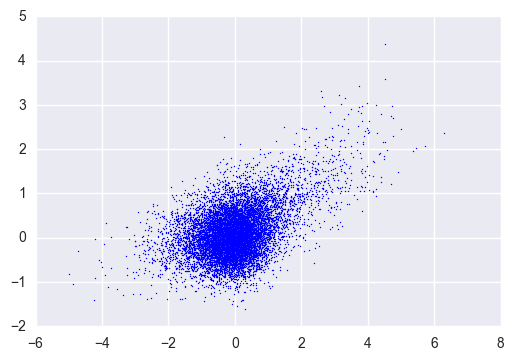

In [32]:
evaluate(s_y_test, normal_model.predict(s_X_test))
evaluate(s_y_test, selective_model.predict(s_X_test))
evaluate(s_y_test, weighted_model.predict(s_X_test))

# Regression on Strongly Changing

12146
SpearmanrResult(correlation=0.72726906150586934, pvalue=0.0)
SpearmanrResult(correlation=0.63878068845213265, pvalue=0.0)


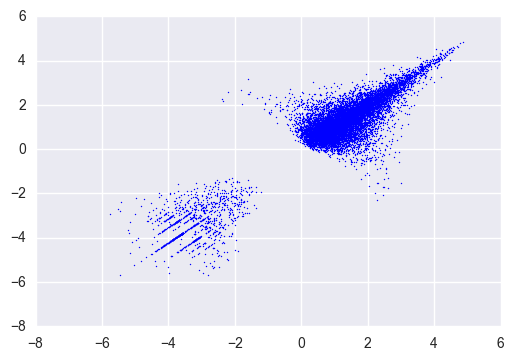

157415
SpearmanrResult(correlation=0.12745251797998494, pvalue=0.0)


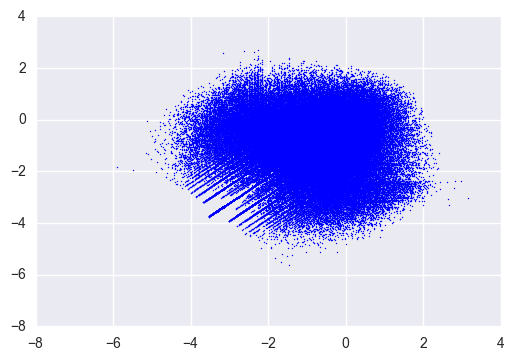

In [39]:
idx = np.logical_and(pvals < .1, d > 20)
a1, a2 = act(r1, d, -1)[idx], act(r2, d, -1)[idx]
sc = plt.scatter(a1, a2,
                 s = 1, lw = 0)
print sum(idx)
print stats.spearmanr(a1, a2)
pos = (a1+a2) / 2.0 > -.5
print stats.spearmanr(a1[pos], a2[pos])
#plt.colorbar(sc)
plt.show()

idx = np.logical_and(pvals > .1, d > 20)
a1, a2 = act(r1, d, -1)[idx], act(r2, d, -1)[idx]
sc = plt.scatter(a1, a2,
                 s = 1, lw = 0)
print sum(idx)
print stats.spearmanr(a1, a2)
#plt.colorbar(sc)
plt.show()

In [41]:
idx = np.logical_and(pvals < .1, d > 20)
d_X = get_X(idx, 6)
d_y = get_y(idx)

(d_X_train, d_X_test,
 d_y_train, d_y_test) = train_test_split(d_X, d_y,
                                     test_size = 0.2,
                                     random_state = 42)

differential_model = SGDRegressor(penalty = 'l1').fit(d_X_train, d_y_train)

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


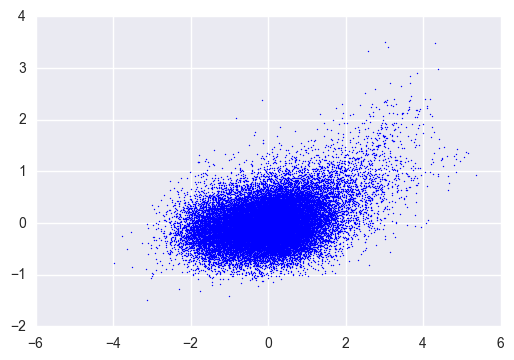

SpearmanrResult(correlation=0.18409287738509328, pvalue=3.0765899484576772e-256)
(0.25137633992933173, 0.0)


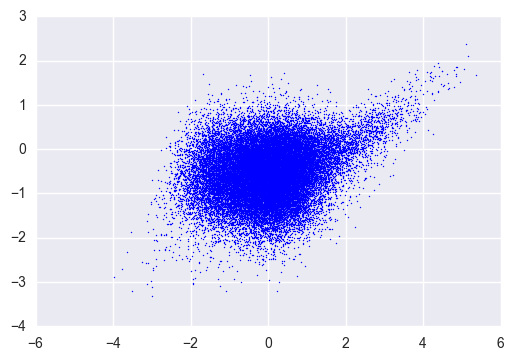

In [42]:
evaluate(y_test, normal_model.predict(X_test))
evaluate(y_test, differential_model.predict(X_test))

SpearmanrResult(correlation=0.53917681378034643, pvalue=2.3769848552315254e-183)
(0.54617273423097945, 4.9649630072072978e-189)


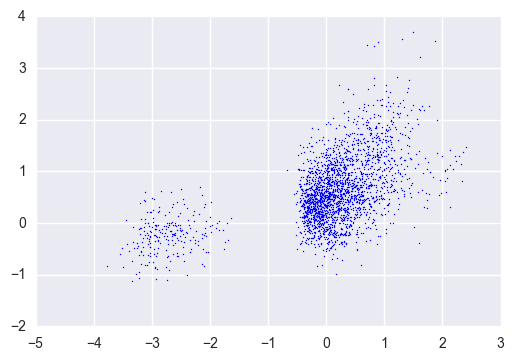

SpearmanrResult(correlation=0.62841367832629946, pvalue=3.5127496805061552e-267)
(0.63287900239003891, 4.0949018196866327e-272)


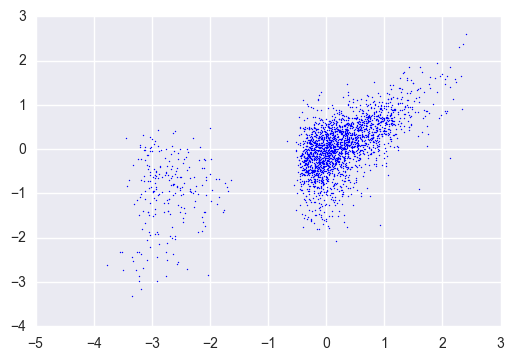

SpearmanrResult(correlation=0.58242082105668003, pvalue=9.9432367096318055e-221)
(0.60199153406451134, 1.4326299844318425e-239)


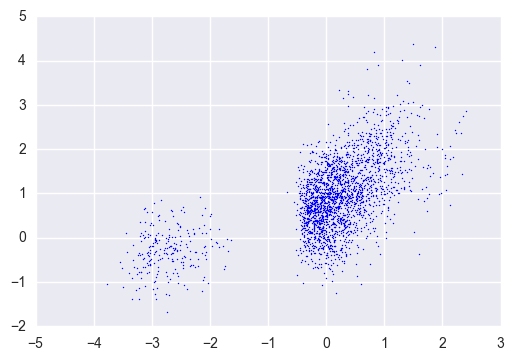

In [44]:
evaluate(d_y_test, normal_model.predict(d_X_test))
evaluate(d_y_test, differential_model.predict(d_X_test))
evaluate(d_y_test, weighted_model.predict(d_X_test))

SpearmanrResult(correlation=0.43068411111905713, pvalue=9.6443472763048724e-100)
(0.45605317222127345, 4.3107506366363129e-113)


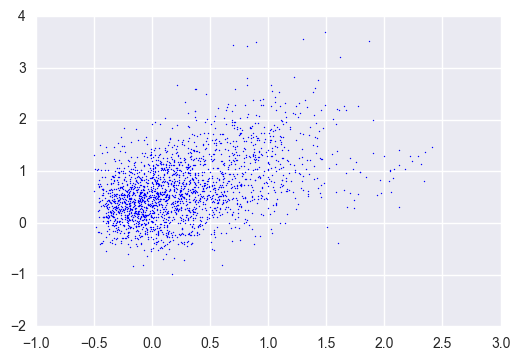

SpearmanrResult(correlation=0.56768991989215445, pvalue=2.5024965258123224e-187)
(0.59442958351313591, 1.1165001154698666e-209)


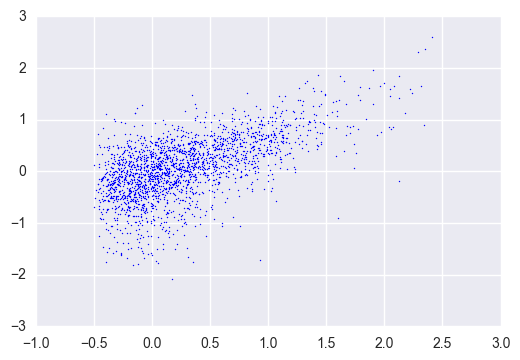

SpearmanrResult(correlation=0.47653111898677936, pvalue=1.0069937673837443e-124)
(0.50181630570581826, 3.194230334847312e-140)


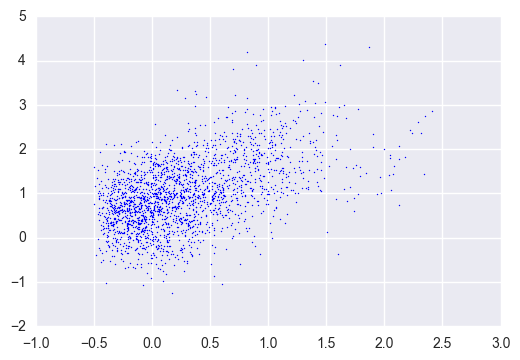

In [45]:
pos_d_y_test = d_y_test[d_y_test > -.5]
pos_d_X_test = d_X_test[d_y_test > -.5]
evaluate(pos_d_y_test, normal_model.predict(pos_d_X_test))
evaluate(pos_d_y_test, differential_model.predict(pos_d_X_test))
evaluate(pos_d_y_test, weighted_model.predict(pos_d_X_test))

# Regression on weakly changing

29538
SpearmanrResult(correlation=0.74736897152581139, pvalue=0.0)
SpearmanrResult(correlation=0.35862162586917262, pvalue=0.0)


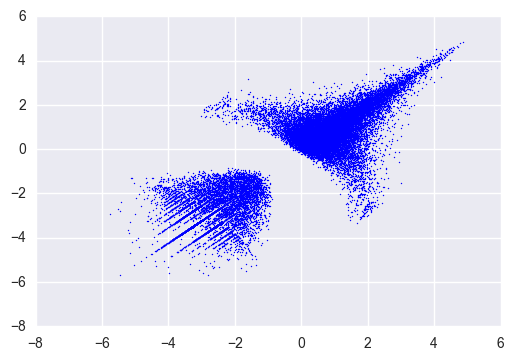

140023
SpearmanrResult(correlation=-0.03613959146367441, pvalue=1.0746730067160602e-41)


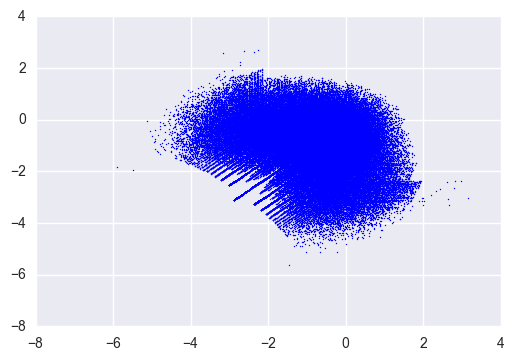

In [48]:
idx = np.logical_and(pvals < .3, d > 20)
a1, a2 = act(r1, d, -1)[idx], act(r2, d, -1)[idx]
sc = plt.scatter(a1, a2,
                 s = 1, lw = 0)
print sum(idx)
print stats.spearmanr(a1, a2)
pos = (a1+a2) / 2.0 > -.5
print stats.spearmanr(a1[pos], a2[pos])
plt.show()

idx = np.logical_and(pvals > .3, d > 20)
a1, a2 = act(r1, d, -1)[idx], act(r2, d, -1)[idx]
sc = plt.scatter(a1, a2,
                 s = 1, lw = 0)
print sum(idx)
print stats.spearmanr(a1, a2)
#plt.colorbar(sc)
plt.show()

In [47]:
idx = np.logical_and(pvals < .3, d > 20)
wd_X = get_X(idx, 6)
wd_y = get_y(idx)

(wd_X_train, wd_X_test,
 wd_y_train, wd_y_test) = train_test_split(wd_X, wd_y,
                                     test_size = 0.2,
                                     random_state = 42)

wd_model = SGDRegressor(penalty = 'l1').fit(wd_X_train,
                                                      wd_y_train)

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


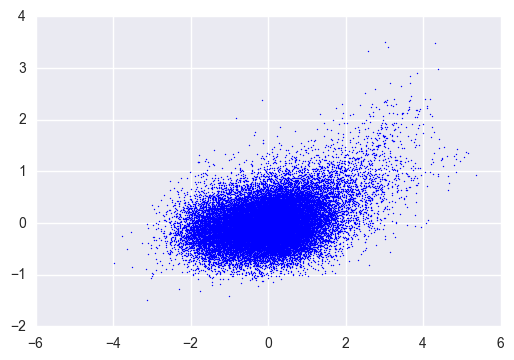

SpearmanrResult(correlation=0.18409287738509328, pvalue=3.0765899484576772e-256)
(0.25137633992933173, 0.0)


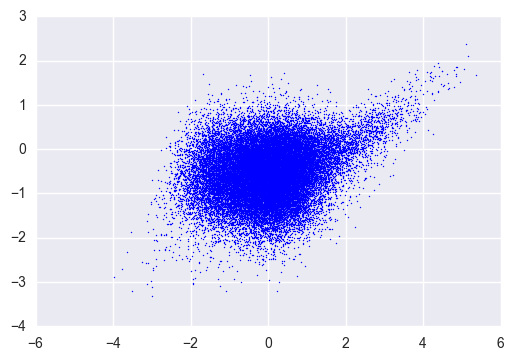

SpearmanrResult(correlation=0.260695558100557, pvalue=0.0)
(0.33975153364660204, 0.0)


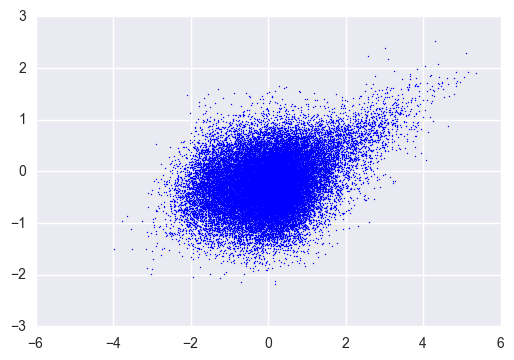

In [49]:
evaluate(y_test, normal_model.predict(X_test))
evaluate(y_test, differential_model.predict(X_test))
evaluate(y_test, wd_model.predict(X_test))

SpearmanrResult(correlation=0.53917681378034643, pvalue=2.3769848552315254e-183)
(0.54617273423097945, 4.9649630072072978e-189)


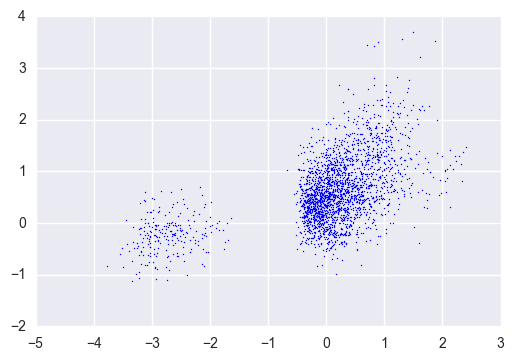

SpearmanrResult(correlation=0.62841367832629946, pvalue=3.5127496805061552e-267)
(0.63287900239003891, 4.0949018196866327e-272)


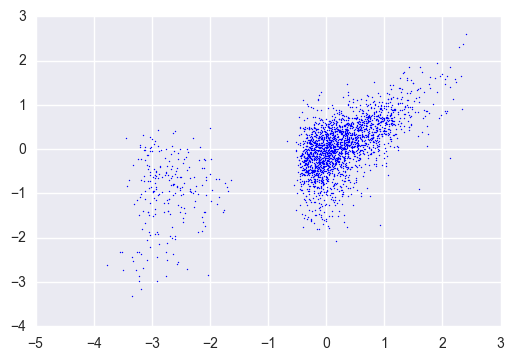

SpearmanrResult(correlation=0.58242082105668003, pvalue=9.9432367096318055e-221)
(0.60199153406451134, 1.4326299844318425e-239)


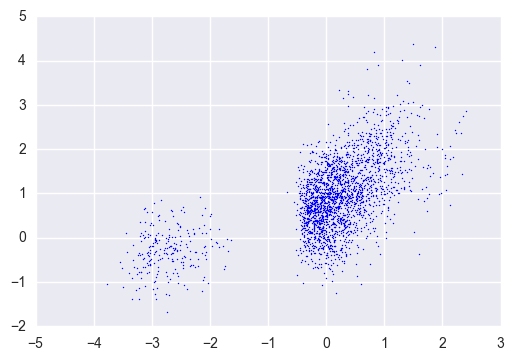

SpearmanrResult(correlation=0.64751357506527341, pvalue=7.2285595181365098e-289)
(0.69105542071213699, 0.0)


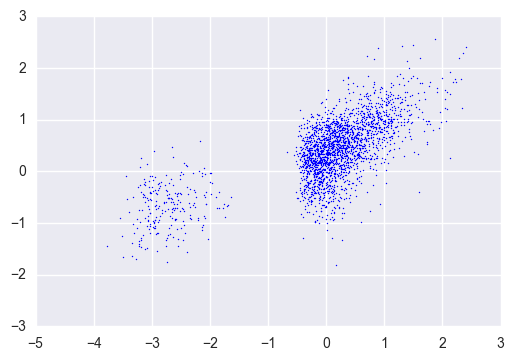

In [50]:
evaluate(d_y_test, normal_model.predict(d_X_test))
evaluate(d_y_test, differential_model.predict(d_X_test))
evaluate(d_y_test, weighted_model.predict(d_X_test))
evaluate(d_y_test, wd_model.predict(d_X_test))

SpearmanrResult(correlation=0.43068411111905713, pvalue=9.6443472763048724e-100)
(0.45605317222127345, 4.3107506366363129e-113)


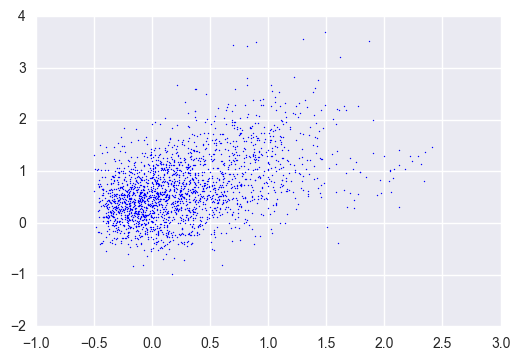

SpearmanrResult(correlation=0.56768991989215445, pvalue=2.5024965258123224e-187)
(0.59442958351313591, 1.1165001154698666e-209)


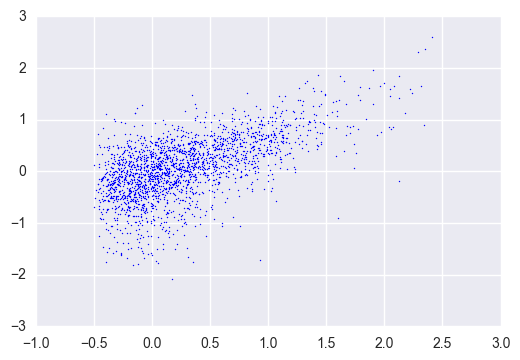

SpearmanrResult(correlation=0.55050147562766127, pvalue=5.2054012596743164e-174)
(0.57169663073362009, 1.5124814823990528e-190)


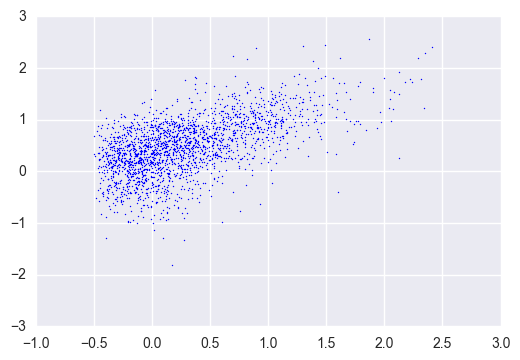

SpearmanrResult(correlation=0.47653111898677936, pvalue=1.0069937673837443e-124)
(0.50181630570581826, 3.194230334847312e-140)


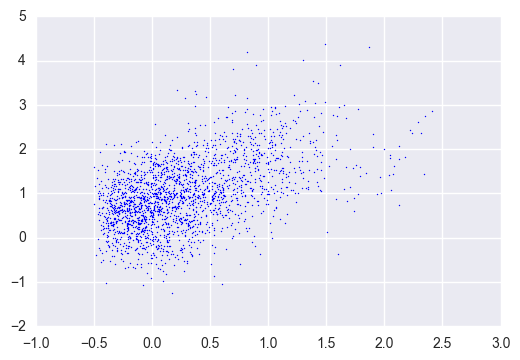

In [51]:
pos_d_y_test = d_y_test[d_y_test > -.5]
pos_d_X_test = d_X_test[d_y_test > -.5]
evaluate(pos_d_y_test, normal_model.predict(pos_d_X_test))
evaluate(pos_d_y_test, differential_model.predict(pos_d_X_test))
evaluate(pos_d_y_test, wd_model.predict(pos_d_X_test))
evaluate(pos_d_y_test, weighted_model.predict(pos_d_X_test))

SpearmanrResult(correlation=0.43423649119776525, pvalue=1.7749205733943004e-187)
(0.52931499333761656, 9.4065680002758172e-294)


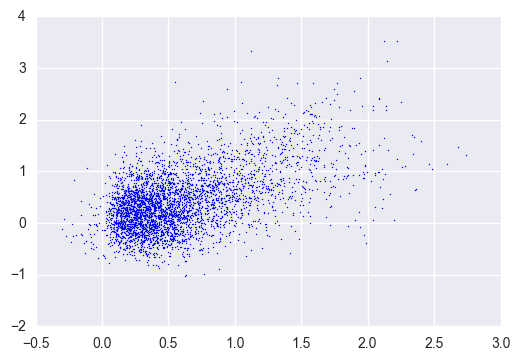

SpearmanrResult(correlation=0.51066218382497008, pvalue=3.6319372458080109e-270)
(0.58275839884052028, 0.0)


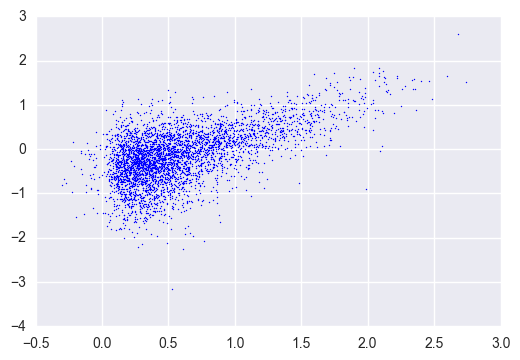

SpearmanrResult(correlation=0.47908184014178207, pvalue=1.978545996216805e-233)
(0.53911760028476741, 9.4130281209651271e-307)


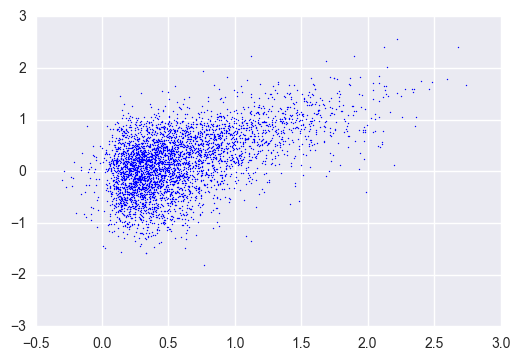

SpearmanrResult(correlation=0.47076573110945463, pvalue=2.2134481374521265e-224)
(0.55642399327374803, 0.0)


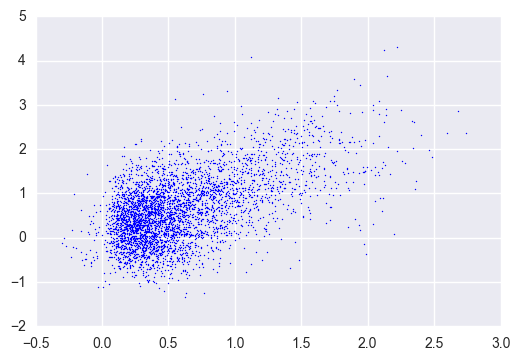

In [52]:
pos_wd_y_test = wd_y_test[wd_y_test > -.5]
pos_wd_X_test = wd_X_test[wd_y_test > -.5]
evaluate(pos_wd_y_test, normal_model.predict(pos_wd_X_test))
evaluate(pos_wd_y_test, differential_model.predict(pos_wd_X_test))
evaluate(pos_wd_y_test, wd_model.predict(pos_wd_X_test))
evaluate(pos_wd_y_test, weighted_model.predict(pos_wd_X_test))

# Sandbox

In [53]:
X = get_X(d > 20, 6)
y = get_y(d > 20)
w = (1-pvals)[d > 20]**2

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

test_model = SGDRegressor(penalty = 'l1').fit(X_train, y_train,
                                              sample_weight = t_w_train)

SpearmanrResult(correlation=0.26958094983859515, pvalue=0.0)
(0.36612852196435131, 0.0)


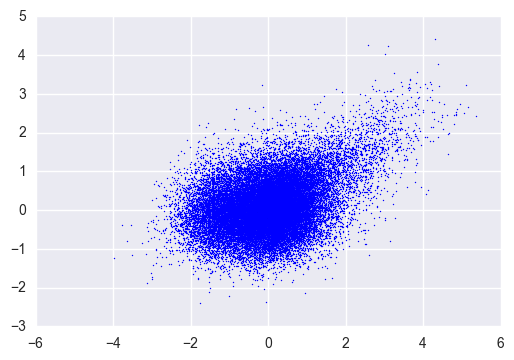

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


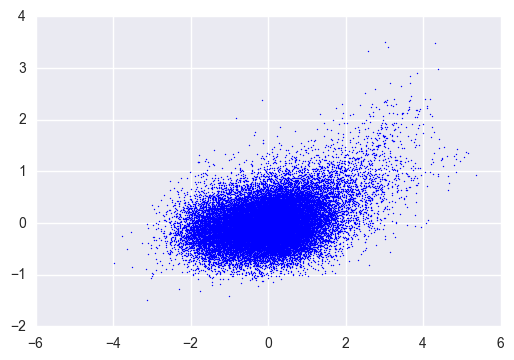

In [54]:
evaluate(y_test,   test_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))

In [55]:
X = get_X(d > 20, 6)
y = get_y(d > 20)
w = np.exp((1-pvals)[d > 20])

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

test_model = SGDRegressor(penalty = 'l1').fit(X_train, y_train,
                                              sample_weight = t_w_train)

SpearmanrResult(correlation=0.27424144540452455, pvalue=0.0)
(0.37685977577684959, 0.0)


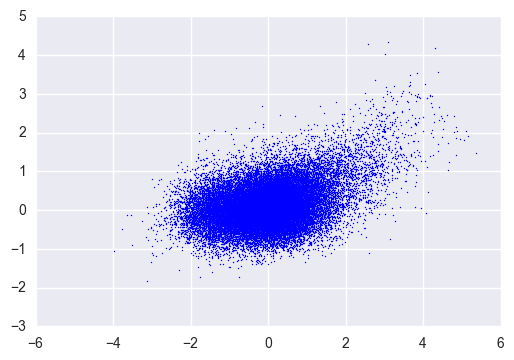

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


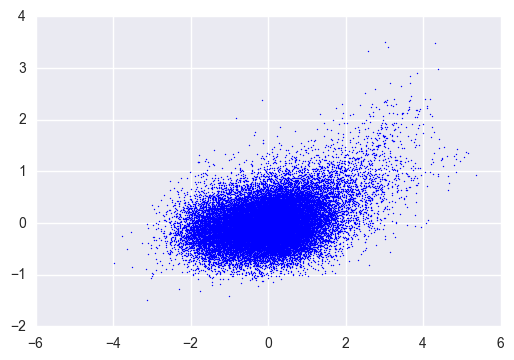

In [56]:
evaluate(y_test,   test_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))

In [57]:
X = get_X(d > 20, 6)
y = get_y(d > 20)
w = (1 / disps)[d > 20]

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

test_model = SGDRegressor(penalty = 'l1').fit(X_train, y_train,
                                              sample_weight = t_w_train)

SpearmanrResult(correlation=0.0082742370674298554, pvalue=0.12758101929023741)
(0.010831175703801045, 0.046086713625308154)


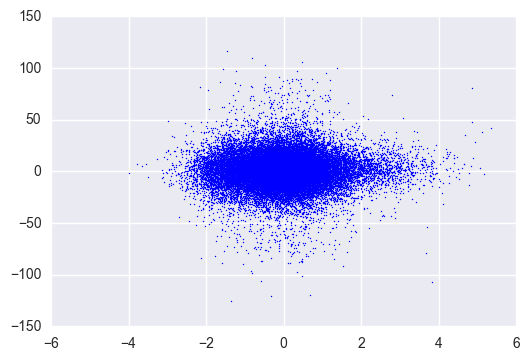

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


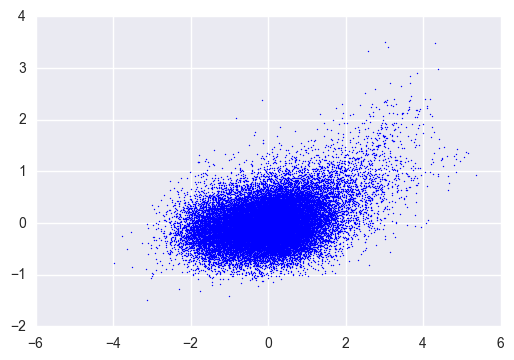

In [58]:
evaluate(y_test,   test_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))

In [59]:
X = get_X(d > 20, 6)
y = get_y(d > 20)
w = d[d > 20]

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

test_model = SGDRegressor(penalty = 'l1').fit(X_train, y_train,
                                              sample_weight = t_w_train)

SpearmanrResult(correlation=-0.016355674777169357, pvalue=0.0025947542372711492)
(-0.020762840712864682, 0.00013138463684711941)


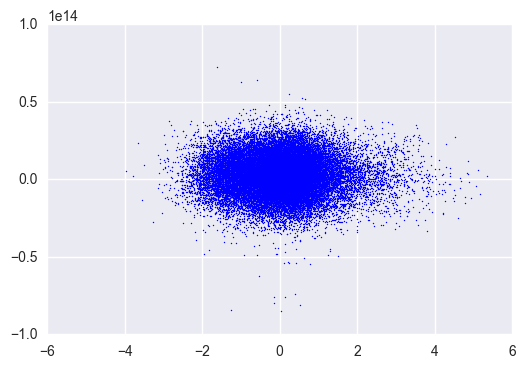

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


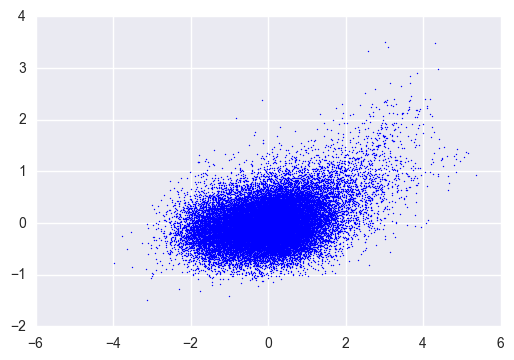

In [60]:
evaluate(y_test,   test_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))

In [61]:
X = get_X(d > 20, 6)
y = get_y(d > 20)
w = np.log(d+1)[d > 20]

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

test_model = SGDRegressor(penalty = 'l1').fit(X_train, y_train,
                                              sample_weight = t_w_train)

SpearmanrResult(correlation=0.010903776762949053, pvalue=0.04464660871293917)
(0.0064993380335034391, 0.23136386065647416)


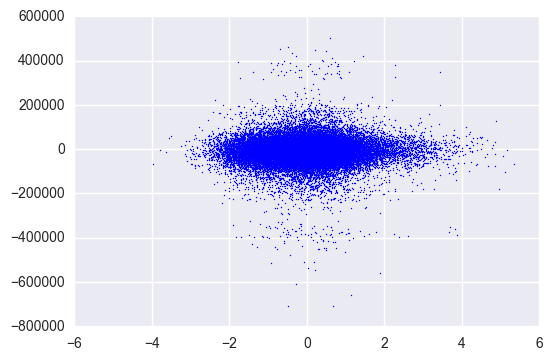

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


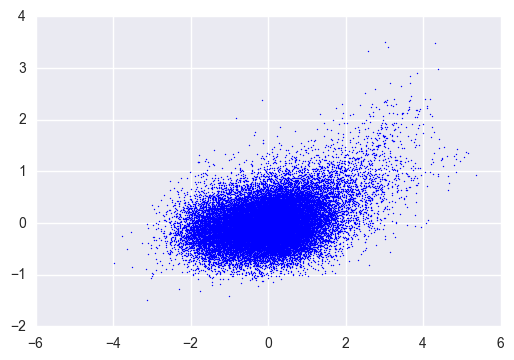

In [62]:
evaluate(y_test,   test_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))

In [63]:
X = get_X(d > 20, 6)
y = get_y(d > 20)
w = d[d > 20] / 1000.0

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

test_model = SGDRegressor(penalty = 'l1').fit(X_train, y_train,
                                              sample_weight = t_w_train)

SpearmanrResult(correlation=0.26470094971782565, pvalue=0.0)
(0.35706240898296271, 0.0)


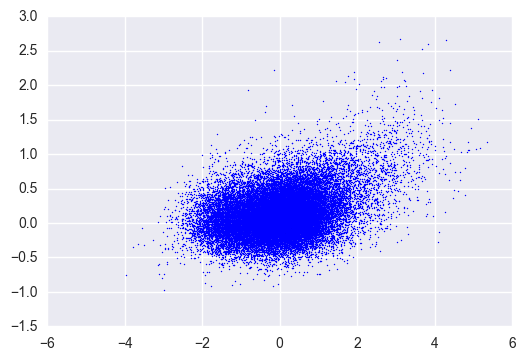

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


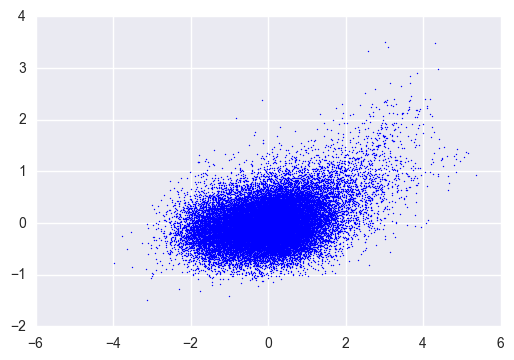

In [64]:
evaluate(y_test,   test_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))

In [65]:
X = get_X(d > 20, 6)
y = get_y(d > 20)
w = d[d > 20] / 500.0

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

test_model = SGDRegressor(penalty = 'l1').fit(X_train, y_train,
                                              sample_weight = t_w_train)

SpearmanrResult(correlation=0.26852781592102315, pvalue=0.0)
(0.36848599595902659, 0.0)


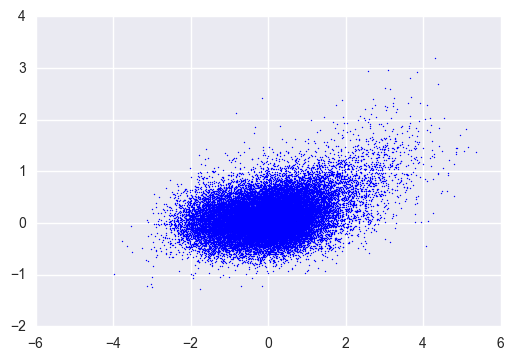

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


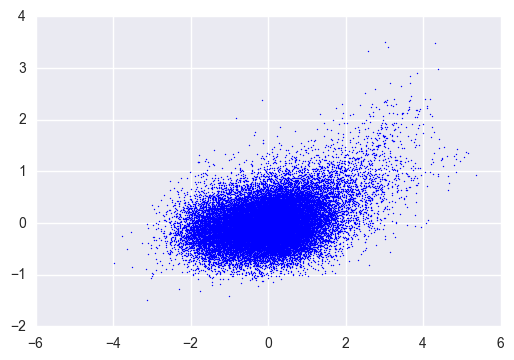

In [66]:
evaluate(y_test,   test_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))

In [67]:
X = get_X(d > 20, 6)
y = get_y(d > 20)
w = d[d > 20] / 100.0

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

test_model = SGDRegressor(penalty = 'l1').fit(X_train, y_train,
                                              sample_weight = t_w_train)

SpearmanrResult(correlation=0.25558915263348181, pvalue=0.0)
(0.3510491963085452, 0.0)


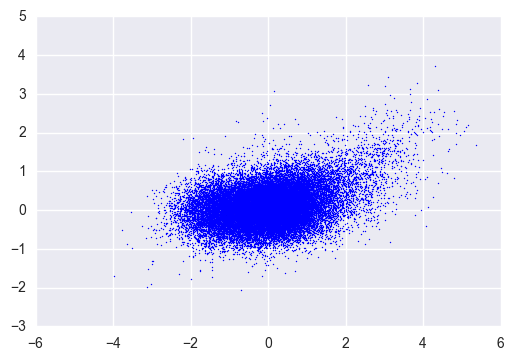

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


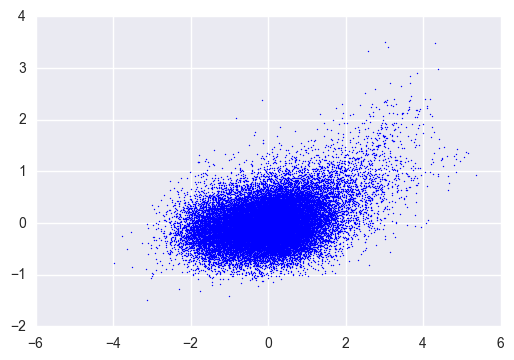

In [68]:
evaluate(y_test,   test_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))

In [71]:
w = map(lambda x: 1 if x > 200 else x / 200.0, d[d > 20])

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

test_model = SGDRegressor(penalty = 'l1').fit(X_train, y_train,
                                              sample_weight = t_w_train)

SpearmanrResult(correlation=0.27474595765123394, pvalue=0.0)
(0.37884708859621619, 0.0)


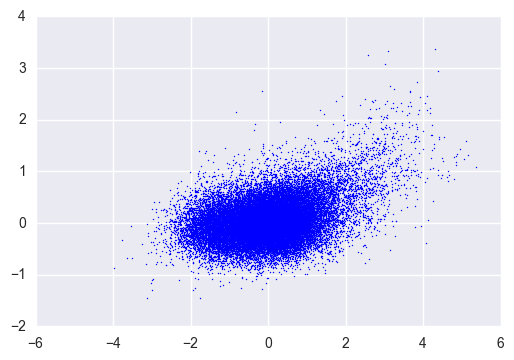

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


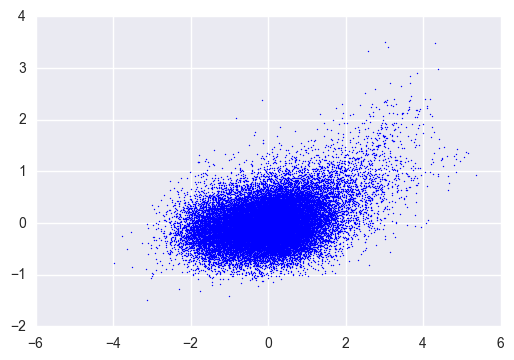

In [72]:
evaluate(y_test,   test_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))

In [73]:
w = map(lambda x: 1 if x > 150 else x / 150.0, d[d > 20])

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

test_model = SGDRegressor(penalty = 'l1').fit(X_train, y_train,
                                              sample_weight = t_w_train)

SpearmanrResult(correlation=0.27437576208120501, pvalue=0.0)
(0.38102909856719597, 0.0)


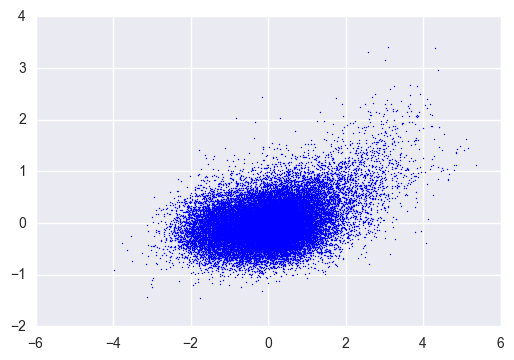

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


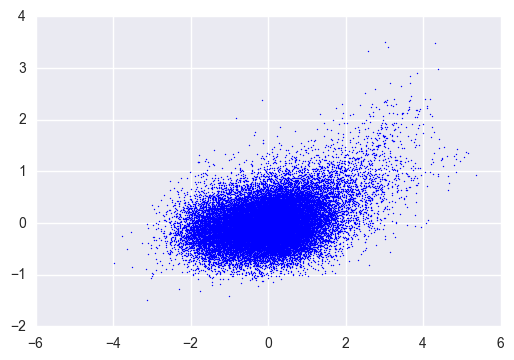

In [74]:
evaluate(y_test,   test_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))

In [75]:
w = map(lambda x: 1 if x > 200 else (x / 200.0)**2, d[d > 20])

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

test_model = SGDRegressor(penalty = 'l1').fit(X_train, y_train,
                                              sample_weight = t_w_train)

SpearmanrResult(correlation=0.26241771272822367, pvalue=0.0)
(0.36927423138151788, 0.0)


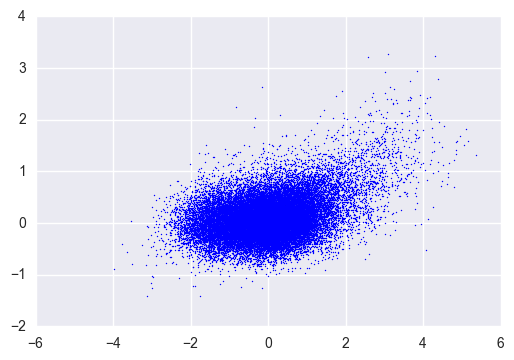

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


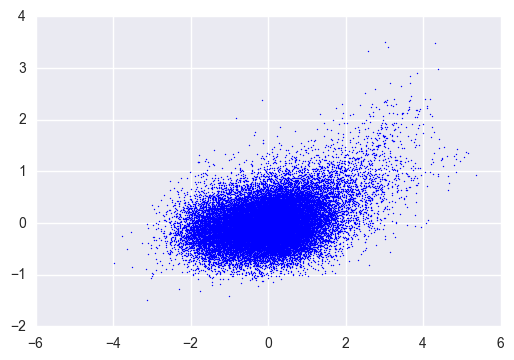

In [76]:
evaluate(y_test,   test_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))

In [77]:
X = get_X(d > 20, 6)
y = get_y(d > 20)
w = np.log(d+1)[d > 20] / 5.0

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

test_model = SGDRegressor(penalty = 'l1').fit(X_train, y_train,
                                              sample_weight = t_w_train)

SpearmanrResult(correlation=0.28075972155934364, pvalue=0.0)
(0.38148701620854292, 0.0)


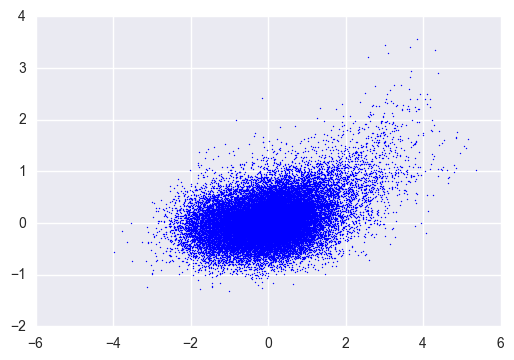

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


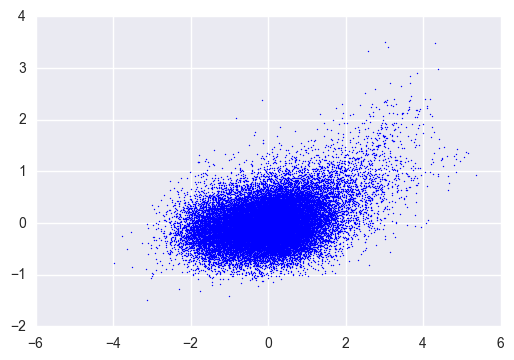

In [78]:
evaluate(y_test,   test_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))

In [81]:
X = get_X(d > 20, 6)
y = get_y(d > 20)
w = np.log(d+1)[d > 20] / 5.0

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

test_model = SGDRegressor(penalty = 'l1',n_iter = 15).fit(X_train, y_train,
                                              sample_weight = t_w_train)

SpearmanrResult(correlation=0.28260152912027131, pvalue=0.0)
(0.38561811614662461, 0.0)


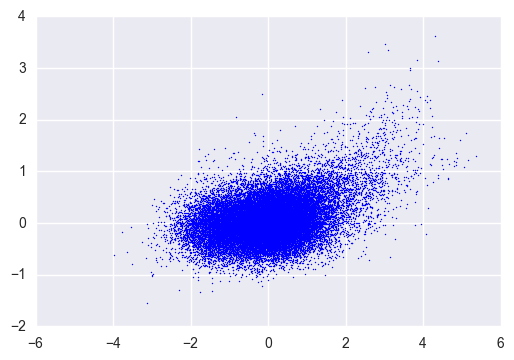

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


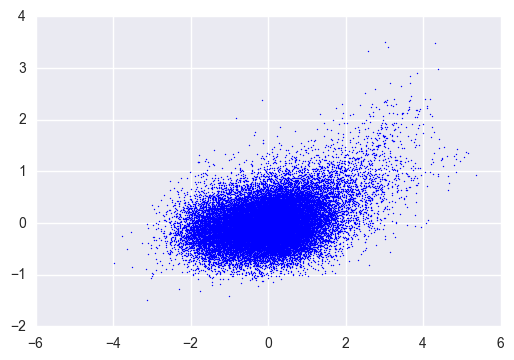

In [82]:
evaluate(y_test,   test_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))

In [83]:
X = get_X(d > 20, 6)
y = get_y(d > 20)
w = np.log(d+1)[d > 20] / 5.0

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

test_model = SGDRegressor(penalty = 'l1',n_iter = 30).fit(X_train, y_train,
                                              sample_weight = t_w_train)

SpearmanrResult(correlation=0.28372908453959111, pvalue=0.0)
(0.38718279764670122, 0.0)


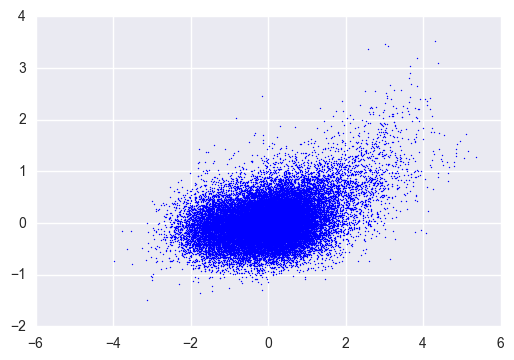

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


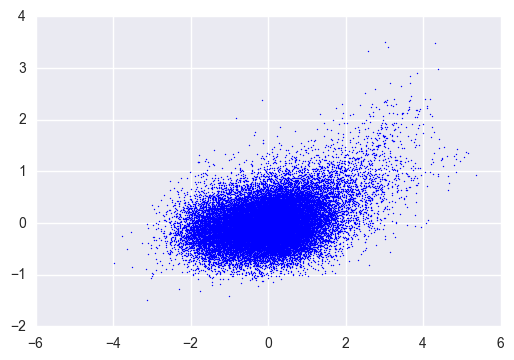

In [84]:
evaluate(y_test,   test_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))

In [85]:
X = get_X(d > 20, 6)
y = get_y(d > 20)
w = np.log(d+1)[d > 20] / 5.0

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

b_model = SGDRegressor(penalty = 'l1',n_iter = 50).fit(X_train, y_train)

SpearmanrResult(correlation=0.28241898726321008, pvalue=0.0)
(0.38614497602875986, 0.0)


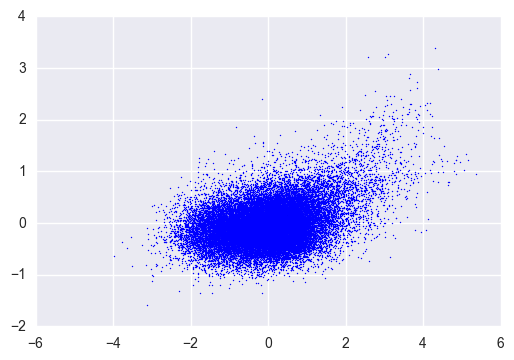

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


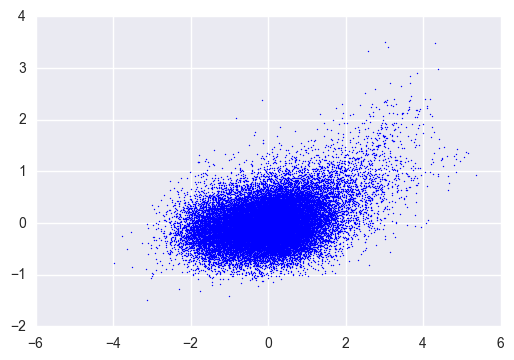

In [86]:
evaluate(y_test,   b_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))

In [104]:
from sklearn.neighbors import KNeighborsRegressor
x = np.vstack([d[d > 20], y]).T
var = np.var(np.vstack([r1, r2]).T, axis = 1)[d > 20]
#pred_var = KNeighborsRegressor().fit(x, var).predict(x)
w = (np.max(var) - var) / np.max(var)

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

test_model = SGDRegressor(penalty = 'l1').fit(X_train, y_train,
                                              sample_weight = t_w_train)

SpearmanrResult(correlation=0.28063280913169586, pvalue=0.0)
(0.37866353619667026, 0.0)


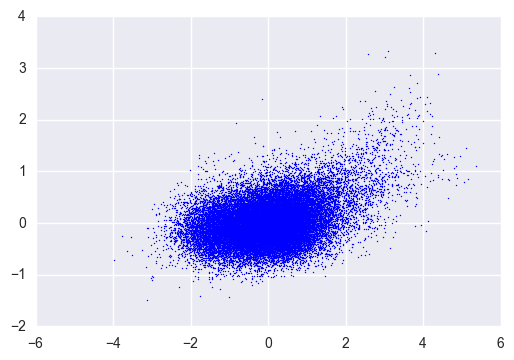

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


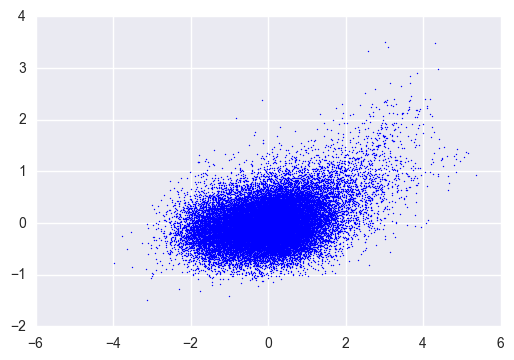

In [105]:
evaluate(y_test, test_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))

In [102]:
from sklearn.neighbors import KNeighborsRegressor
x = np.vstack([d[d > 20], y]).T
var = np.var(np.vstack([r1, r2]).T, axis = 1)[d > 20]
pred_var = KNeighborsRegressor(n_neighbors = 500).fit(x, var).predict(x)
w = (np.max(pred_var) - pred_var) / np.max(pred_var)

(X_train, X_test,
 y_train, y_test,
 t_w_train, t_w_test) = train_test_split(X, y, w,
                                     test_size = 0.2,
                                     random_state = 42)

test_model = SGDRegressor(penalty = 'l1').fit(X_train, y_train,
                                              sample_weight = t_w_train)

SpearmanrResult(correlation=0.27646325386359138, pvalue=0.0)
(0.37555086708537966, 0.0)


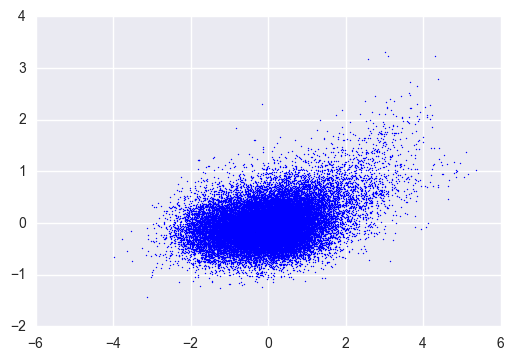

SpearmanrResult(correlation=0.27736540406534282, pvalue=0.0)
(0.3784262104808338, 0.0)


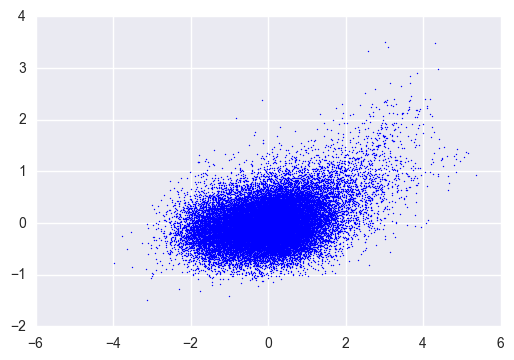

In [103]:
evaluate(y_test,   test_model.predict(X_test))
evaluate(y_test, normal_model.predict(X_test))